<a href="https://colab.research.google.com/github/SergeiSa/Control-Theory-Slides-Spring-2021/blob/main/ColabNotebooks/Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Run all cells

Look for instructions below


In [ ]:
!apt-get install clang-9
!git clone https://github.com/RumblingTurtle/SrdPy.git
!pip install git+https://github.com/rdeits/meshcat-python.git@master
!pip install ./SrdPy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  binfmt-support libclang-common-9-dev libclang-cpp9 libclang1-9 libffi-dev
  libllvm9 libomp-9-dev libomp5-9 libpfm4 llvm-9 llvm-9-dev llvm-9-runtime
  llvm-9-tools python-chardet python-pkg-resources python-pygments python-yaml
  python3-pkg-resources python3-pygments python3-yaml
Suggested packages:
  clang-9-doc libomp-9-doc llvm-9-doc python-setuptools ttf-bitstream-vera
  python3-setuptools
The following NEW packages will be installed:
  binfmt-support clang-9 libclang-common-9-dev libclang-cpp9 libclang1-9
  libffi-dev libllvm9 libomp-9-dev libomp5-9 libpfm4 llvm-9 llvm-9-dev
  llvm-9-runtime llvm-9-tools python-chardet python-pkg-resources
  python-pygments python-yaml python3-pkg-resources python3-pygments
  python3-yaml
0 upgraded, 21 newly installed, 0 to remove and 31 not upgraded.
Need to get 85.9 MB of archives.
After this op

In [ ]:
from SrdPy.URDFUtils import getLinkArrayFromURDF

from SrdPy.TableGenerators import generateConstraiedLinearModelTable
from SrdPy.TableGenerators import generateLinearModelTable
from SrdPy.LinksAndJoints import *
from SrdPy.Handlers import *
from SrdPy.InverseKinematics import *
from SrdPy.SymbolicUtils import *
from SrdPy.Loggers import *
from SrdPy.DynamicSolvers import *
from SrdPy.Controllers import *

from SrdPy.Visuals import Visualizer
from SrdPy import SymbolicEngine
from SrdPy import plotGeneric
from copy import deepcopy
from casadi import *

from SrdPy.TableGenerators import *
from SrdPy import Chain
from SrdPy import Profiler
import numpy as np
from scipy.integrate import solve_ivp
import os

In [ ]:
p = Profiler()
iiwaLinks = getLinkArrayFromURDF(os.path.abspath("./SrdPy/examples/iiwa/iiwa14.urdf"),True)
iiwaChain = Chain(iiwaLinks)


print(iiwaChain)
initialPosition = np.array([0.1701584,  -0.07586424,  0.42323069, -0.41380217,  0.01195943,  0.07095069,
  0.])
blank_chain = deepcopy(iiwaChain)
blank_chain.update(initialPosition)

engine = SymbolicEngine(iiwaChain.linkArray)

deriveJacobiansForlinkArray(engine)
H = deriveJSIM(engine)

iN, dH = deriveGeneralizedInertialForces_dH(engine, H)
g = deriveGeneralizedGravitationalForces(engine)
d = deriveGeneralizedDissipativeForcesUniform(engine, 1)
T = deriveControlMap(engine)


description_gen_coord_model = generateDynamicsGeneralizedCoordinatesModel(engine,
                                                                          H=H,
                                                                          c=(iN + g + d),
                                                                          T=T,
                                                                          functionName_H="g_dynamics_H",
                                                                          functionName_c="g_dynamics_c",
                                                                          functionName_T="g_dynamics_T",
                                                                          casadi_cCodeFilename="g_dynamics_generalized_coordinates",
                                                                          path="./iiwa/Dynamics")

handlerGeneralizedCoordinatesModel = GeneralizedCoordinatesModelHandler(description_gen_coord_model)

description_linearization = generateDynamicsLinearization(engine,
                                                          H=H,
                                                          c=(iN + g + d),
                                                          T=T,
                                                          functionName_A="g_linearization_A",
                                                          functionName_B="g_linearization_B",
                                                          functionName_c="g_linearization_c",
                                                          casadi_cCodeFilename="g_dynamics_linearization",
                                                          path="./iiwa/Linearization")
                                                          
handlerLinearizedModel = LinearizedModelHandler(description_linearization)

constraint6 = engine.links["iiwa_link_6"].absoluteFollower[0]

task = constraint6[:2]
print("task size is: ", task.size)


description_IK = generateSecondDerivativeJacobians(engine,
                                                task=task,
                                                functionName_Task="g_InverseKinematics_Task",
                                                functionName_TaskJacobian="g_InverseKinematics_TaskJacobian",
                                                functionName_TaskJacobianDerivative="g_InverseKinematics_TaskJacobian_derivative",
                                                casadi_cCodeFilename="g_InverseKinematics",
                                                path="./iiwa/InverseKinematics")

ikModelHandler = IKModelHandler(description_IK, engine.dof, task.shape[0])

Unknown tag: material
Unknown tag: self_collision_checking
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface


Parsing URDF:/content/SrdPy/examples/iiwa/iiwa14.urdf
Root node: base
Chain
Links: 
0. Ground 
1. iiwa_link_0 
2. iiwa_link_1 
3. iiwa_link_2 
4. iiwa_link_3 
5. iiwa_link_4 
6. iiwa_link_5 
7. iiwa_link_6 
8. iiwa_link_7 

Starting writing function for the g_dynamics_H
Starting writing function for the g_dynamics_c
Starting writing function for the g_dynamics_T
Running gcc
Generated C code!
Starting writing function for the g_linearization_A
Starting writing function for the g_linearization_B
Running gcc
Generated C code!
task size is:  2
Starting writing function for the g_InverseKinematics_Task
Starting writing function for the g_InverseKinematics_Task task jacobian
Starting writing function for the derivative of g_InverseKinematics_Task
Generated C code!


Calculating  0.0%
Calculating  0.0%
Calculating  1.0%
Calculating  2.0%
Calculating  3.0%
Calculating  4.0%
Calculating  5.0%
Calculating  6.0%
Calculating  7.0%
Calculating  8.0%
Calculating  9.0%
Calculating  10.0%
Calculating  11.0%
Calculating  12.0%
Calculating  13.0%
Calculating  14.0%
Calculating  15.0%
Calculating  16.0%
Calculating  17.0%
Calculating  18.0%
Calculating  19.0%
Calculating  20.0%
Calculating  21.0%
Calculating  22.0%
Calculating  23.0%
Calculating  24.0%
Calculating  25.0%
Calculating  26.0%
Calculating  27.0%
Calculating  28.0%
Calculating  29.0%
Calculating  30.0%
Calculating  31.0%
Calculating  32.0%
Calculating  33.0%
Calculating  34.0%
Calculating  35.0%
Calculating  36.0%
Calculating  37.0%
Calculating  38.0%
Calculating  39.0%
Calculating  40.0%
Calculating  41.0%
Calculating  42.0%
Calculating  43.0%
Calculating  44.0%
Calculating  45.0%
Calculating  46.0%
Calculating  47.0%
Calculating  48.0%
Calculating  49.0%
Calculating  50.0%
Calculating  51.0%
Calc

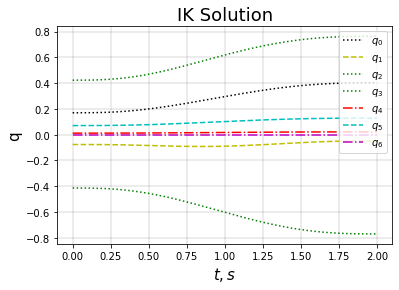

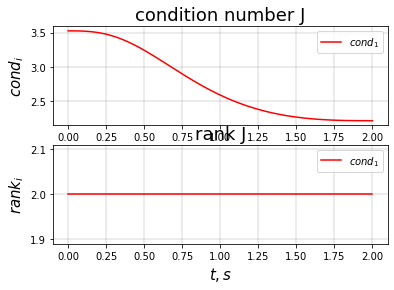

In [ ]:
IC_task = ikModelHandler.getTask(initialPosition)

task_1 = np.array([[0.1],  [0.3]])
# task_2 = np.array([[0.3],  [0.3]])
# task_3 = np.array([[0.3],  [0.1]])

# zeroOrderDerivativeNodes = np.hstack((IC_task, task_1, task_2, task_3))
zeroOrderDerivativeNodes = np.hstack((IC_task, task_1))

firstOrderDerivativeNodes = np.zeros(zeroOrderDerivativeNodes.shape)

secondOrderDerivativeNodes = np.zeros(zeroOrderDerivativeNodes.shape)

timeOfOneStage = 2
timeEnd = (len(zeroOrderDerivativeNodes[1]) - 1) * timeOfOneStage + 1
nodeTimes = np.arange(start=0, stop=timeEnd, step=timeOfOneStage)

handlerIK_taskSplines = IKtaskSplinesHandler(nodeTimes,
                                                zeroOrderDerivativeNodes, 
                                                firstOrderDerivativeNodes,
                                                secondOrderDerivativeNodes)

timeTable = np.arange(handlerIK_taskSplines.timeStart, handlerIK_taskSplines.timeExpiration + 0.01, 0.01)

IKTable = generateIKTable(ikModelHandler, handlerIK_taskSplines, initialPosition, timeTable, method="lsqnonlin")
plotIKTable(ikModelHandler, timeTable, IKTable)

ikSolutionHandler = IKSolutionHandler(ikModelHandler, handlerIK_taskSplines, timeTable, IKTable, "linear")

tf = ikSolutionHandler.timeExpiration

n = handlerGeneralizedCoordinatesModel.dofConfigurationSpaceRobot

A_table, B_table, c_table, x_table, u_table, dx_table = generateLinearModelTable(handlerGeneralizedCoordinatesModel,handlerLinearizedModel,ikSolutionHandler,timeTable)


# Task

 

1. Implement control, but state observer (x can't be used by the controller, but $y = Cx$ can be)
2. Simulate the system with the observer and the controller
3. Simulate from different initial positions



In [ ]:
from control import lqr

def my_generateLQRTable(A_table, B_table, Q_table, R_table):
    count = A_table.shape[0]
    n = A_table.shape[2]
    m = B_table.shape[2]

    K_table = np.zeros((count,m,n))

    for i in range(count):
        K, S, CLP =  lqr(A_table[i], B_table[i], Q_table[i], R_table[i])
        K_table[i] = K
        
    return K_table

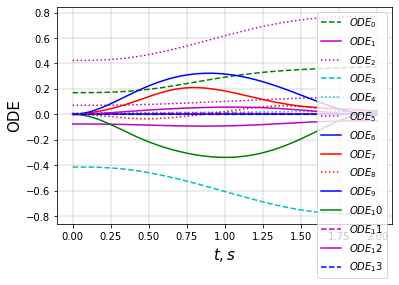

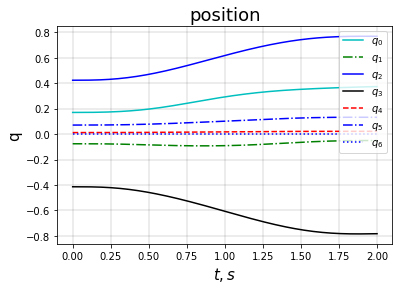

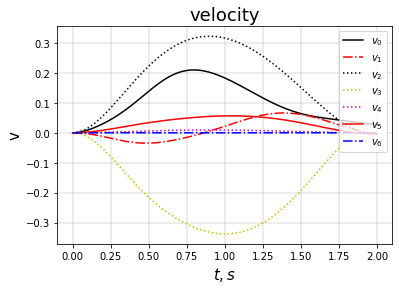

In [ ]:
С = np.concatenate((np.eye(n), np.zeros((n, n))), axis=1) #y = C*x

Q = 10*np.eye(2 * n)
R = 0.1*np.eye(handlerGeneralizedCoordinatesModel.dofControl)
count = A_table.shape[0]

#Controller gains
K_table = my_generateLQRTable(A_table, B_table, np.tile(Q, [count,1, 1]), np.tile(R, [ count, 1, 1]))
#Closed-loop system
AA_table, cc_table = generateCloseLoopTable(A_table, B_table, c_table, K_table, x_table, u_table)

#Initial positions
x0 = np.hstack((initialPosition, np.zeros(initialPosition.shape[0])))

#Simulation
ode_fnc_handle = ClosedLoopLinearSystemOdeFunctionHandler(AA_table, cc_table, timeTable)
sol = solve_ivp(ode_fnc_handle, [0, tf], x0, t_eval=timeTable,method="RK45")

# plot graphs
time_table_0 = sol.t
solution_tape = sol.y.T

ax = plotGeneric(time_table_0,solution_tape,figureTitle="",ylabel="ODE")
# ax = plotGeneric(timeTable,x_table,ylabel="linearmodel",old_ax = ax, plot=True)

ax = plotGeneric(timeTable,solution_tape[:,:n],figureTitle="position",ylabel="q", plot=True)
ax = plotGeneric(timeTable,solution_tape[:,n:2*n],figureTitle="velocity",ylabel="v", plot=True)

with open('anim_array.npy', 'wb') as f:
    np.save(f, solution_tape[:,:n])

Unknown tag: material
Unknown tag: self_collision_checking
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface


Parsing URDF:/content/SrdPy/examples/iiwa/iiwa14.urdf
Root node: base
Chain
Links: 
0. Ground 
1. iiwa_link_0 
2. iiwa_link_1 
3. iiwa_link_2 
4. iiwa_link_3 
5. iiwa_link_4 
6. iiwa_link_5 
7. iiwa_link_6 
8. iiwa_link_7 



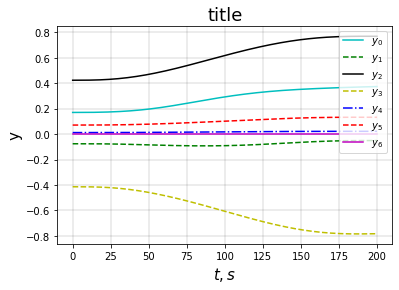

You can open the visualizer by visiting the following URL:
http://c15d8eabc48b.ngrok.io/static/
No mesh: Ground


In [ ]:
chainLinks = getLinkArrayFromURDF(os.path.abspath("./SrdPy/examples/iiwa/iiwa14.urdf"),True)
chain = Chain(chainLinks)

print(chain)
blank_chain = deepcopy(chain)
blank_chain.update(initialPosition)
with open('anim_array.npy', 'rb') as f:
    q = np.load(f)

blank_chain.update(q[0])
plotGeneric(np.arange(q.shape[0]),q,plot=True)
vis = Visualizer()
vis.animate(blank_chain,q,framerate=0.1,showMeshes=True)

Click the link above to see animation ^^^